In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn import metrics
from sklearn import set_config 
from sklearn.utils import estimator_html_repr 
from IPython.core.display import display, HTML 
from category_encoders import TargetEncoder

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import sys

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
df = pd.read_pickle('../data/interim/train_clean_roll_up.pickle')

In [3]:
df = df.sample(frac=0.01)

In [4]:
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_encoded,AppVersion_encoded,EngineVersion_encoded,OsVer_encoded,Census_OSBranch_release_encoded,IsProtected_encoded,RAM_bins
2955860,win8defender,7.0,0,48510.0,2.0,1.0,1,171,131212.0,48.0,...,1,3.0,0,275,18,15200,10.0,rs3_release,2.0,4-8 GB
4415978,win8defender,7.0,0,46413.0,2.0,1.0,1,207,100797.0,27.0,...,1,13.0,0,275,18,15200,10.0,rs3_release,2.0,16-32 GB
3730385,win8defender,7.0,0,53447.0,1.0,1.0,1,214,117596.0,18.0,...,0,1.0,1,273,18,15100,10.0,rs3_release,2.0,4-8 GB
514336,win8defender,7.0,0,53447.0,1.0,1.0,1,214,24184.0,27.0,...,0,1.0,1,275,18,15200,10.0,rs3_release,2.0,2-4 GB
4263548,win8defender,7.0,0,53447.0,1.0,1.0,1,118,156810.0,NaN,...,1,3.0,1,273,18,15100,10.0,rs4_release,2.0,16-32 GB


In [5]:
df.shape

(83953, 72)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83953 entries, 2955860 to 2993910
Data columns (total 72 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   ProductName                                        83953 non-null  category
 1   RtpStateBitfield                                   83650 non-null  category
 2   IsSxsPassiveMode                                   83953 non-null  Int64   
 3   AVProductStatesIdentifier                          83637 non-null  category
 4   AVProductsInstalled                                83637 non-null  category
 5   AVProductsEnabled                                  83637 non-null  category
 6   HasTpm                                             83953 non-null  Int64   
 7   CountryIdentifier                                  83953 non-null  category
 8   CityIdentifier                                     80862 non-null  c

In [7]:
X = df.loc[:, df.columns != 'HasDetections']
y = df['HasDetections']

In [8]:
#Seperate train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(67162, 71)
(16791, 71)
(67162,)
(16791,)


In [9]:
y_train.mean(), y_test.mean()

(0.4970221256067419, 0.49574176642248824)

In [10]:
y_train.dtype, y_test.dtype

(Int64Dtype(), Int64Dtype())

In [11]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [12]:
id_col = ['AVProductStatesIdentifier',
                  'CountryIdentifier',
                  'CityIdentifier',
                  'OrganizationIdentifier',
                  'GeoNameIdentifier',
                  'LocaleEnglishNameIdentifier',
                  'IeVerIdentifier',
                  'Census_OEMNameIdentifier',
                  'Census_OEMModelIdentifier',
                  'Census_ProcessorManufacturerIdentifier',
                  'Census_ProcessorModelIdentifier',
                  'Census_OSInstallLanguageIdentifier',
                  'Census_OSUILocaleIdentifier',
                  'Census_FirmwareManufacturerIdentifier',
                  'Census_FirmwareVersionIdentifier',
                  'Wdft_RegionIdentifier',
                  'Census_OSBuildRevision']
cat_col = [col for col in X_train.select_dtypes('category').columns.tolist() 
           if col not in id_col]
binary_col = X_train.select_dtypes('Int64').columns.tolist()
num_col = [col for col in X_train.columns 
           if col not in cat_col
           if col not in id_col
           if col not in binary_col]

len(cat_col), len(id_col), len(binary_col), len(num_col) 

(33, 17, 14, 7)

In [13]:
len(cat_col) + len(id_col) + len(binary_col) + len(num_col)

71

In [14]:
[X_train[col].dtype for col in cat_col]

[CategoricalDtype(categories=['mse', 'win8defender', 'mseprerelease', 'windowsintune',
                   'fep', 'scep'],
 , ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 3.0, 5.0, 7.0, 8.0, 35.0], ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ordered=False),
 CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], ordered=False),
 CategoricalDtype(categories=['windows10', 'windows2016', 'windows7', 'windows8'], ordered=False),
 CategoricalDtype(categories=['arm64', 'x64', 'x86'], ordered=False),
 CategoricalDtype(categories=['10240', '10586', '14393', '15063', '16299', '17134', '7601',
                   '9600', 'Other'],
 , ordered=False),
 CategoricalDtype(categories=['256', '768', 'Other'], ordered=False),
 CategoricalDtype(categories=['prers5', 'rs1', 'rs2', 'rs3', 'rs4', 'th1', 'th2',
                   'windows7', 'windows8.1'],
 , ordered=False),
 CategoricalDtype(categories=['Cloud', 'Education', 'Enterprise', 'Enterprise 

In [15]:
for col in cat_col:
    X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col][X_test[col].notnull()].astype('str')
    X_test[col] = X_test[col].astype('category')

<ipython-input-15-6d7a0ba9679c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
<ipython-input-15-6d7a0ba9679c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
<ipython-input-15-6d7a0ba9679c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
[X_train[col].dtype for col in cat_col]

[CategoricalDtype(categories=['mse', 'mseprerelease', 'scep', 'win8defender'], ordered=False),
 CategoricalDtype(categories=['0.0', '1.0', '3.0', '5.0', '7.0', '8.0'], ordered=False),
 CategoricalDtype(categories=['1.0', '2.0', '3.0', '4.0', '5.0', '6.0'], ordered=False),
 CategoricalDtype(categories=['0.0', '1.0', '2.0', '3.0', '4.0'], ordered=False),
 CategoricalDtype(categories=['windows10', 'windows2016', 'windows7', 'windows8'], ordered=False),
 CategoricalDtype(categories=['arm64', 'x64', 'x86'], ordered=False),
 CategoricalDtype(categories=['10240', '10586', '14393', '15063', '16299', '17134', '7601',
                   '9600', 'Other'],
 , ordered=False),
 CategoricalDtype(categories=['256', '768', 'Other'], ordered=False),
 CategoricalDtype(categories=['prers5', 'rs1', 'rs2', 'rs3', 'rs4', 'th1', 'th2',
                   'windows7', 'windows8.1'],
 , ordered=False),
 CategoricalDtype(categories=['Cloud', 'Education', 'Enterprise', 'Enterprise LTSB',
                   'Home',

In [17]:
#for col in id_col:
#    X_train[col] = X_train[col][X_train[col].notnull()].astype('str')
#    X_train[col] = X_train[col].astype('category')
#    X_test[col] = X_test[col][X_test[col].notnull()].astype('str')
#    X_test[col] = X_test[col].astype('category')

In [18]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
id_transformer = SimpleImputer() #TargetEncoder(smoothing=10000)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('bin', binary_transformer, binary_col),
        ('id', id_transformer, id_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [19]:
# Define model
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', 
                            eval_metric='logloss', 
                            use_label_encoder =False,
                            verbosity=0)

VarThresh = VarianceThreshold()
#selector = SelectKBest(f_classif)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('VarThresh', VarThresh),
                            #('selector', selector),
                            ('classifier', xgb_clf)
                            ])

In [20]:
set_config(display='diagram')
display(HTML(estimator_html_repr(pipeline)))

In [21]:
parameters ={'preprocessor__num__strategy': ['mean', 'median'],
              'preprocessor__bin__strategy': ['most_frequent'],
              'preprocessor__id__strategy': ['most_frequent'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__learning_rate': [0.1, 0.3, 0.5],
              'classifier__gamma' : [0, 2, 5],
              'classifier__max_depth': range(1, 9, 2),
              #'classifier__colsample_bytree': [0.8, 1.0],
              'classifier__subsample': [0.5, 1],
              #'classifier__reg_alpha': [0, 0.5, 1, 10, 100],
              #'classifier__reg_lambda': [0, 0.5, 1, 1.5],
              'classifier__min_child_weight': [0.5, 1, 3],
              'classifier__n_estimators': [500, 1000, 1500, 2000]}

# Grid search
search = RandomizedSearchCV(estimator=pipeline, 
                             param_distributions=parameters,
                             n_iter = 20,
                             cv=3,
                             scoring = 'roc_auc',
                             return_train_score=True,
                             random_state=42,
                             #n_jobs = -1,
                             verbose=3)

# Preprocessing of training data, fit model 
search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__min_child_weight=3, classifier__n_estimators=2000, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.716, test=0.697) total time=  49.0s
[CV 2/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__min_child_weight=3, classifier__n_estimators=2000, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.717, test=0.696) total time=  47.4s
[CV 3/3] END classifier__gamma=0, classifier__learning_rate=0.3, classifier__max_depth=1, classifier__min_child_weight=3, classifier_

[CV 1/3] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__min_child_weight=3, classifier__n_estimators=1500, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.704, test=0.697) total time=  38.2s
[CV 2/3] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__min_child_weight=3, classifier__n_estimators=1500, classifier__subsample=0.7, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=mean;, score=(train=0.705, test=0.695) total time=  36.8s
[CV 3/3] END classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=1, classifier__min_child_weight=3, classifier__n_estimators=1500, classifier__subsample=0.7, preprocessor__bin__strat

[CV 1/3] END classifier__gamma=0.1, classifier__learning_rate=0.5, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=2000, classifier__subsample=0.3, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=1.000, test=0.616) total time= 2.8min
[CV 2/3] END classifier__gamma=0.1, classifier__learning_rate=0.5, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=2000, classifier__subsample=0.3, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__strategy=most_frequent, preprocessor__num__strategy=median;, score=(train=1.000, test=0.616) total time= 2.8min
[CV 3/3] END classifier__gamma=0.1, classifier__learning_rate=0.5, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=2000, classifier__subsample=0.3, prep

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                                                '...
                                        'classifier__n_estimators': [500, 1000,
                                                                     1500,
                                                                     2000],
                                        'classifier__subsample': [0.3, 0.5,
                                                                  0.7],
                                        'preprocessor__bin__strategy': ['most_frequent'],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__id__strategy': ['most_frequent'],
                                        'preprocessor__num__strategy': ['mean',
                                                                        'median']},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=3)

In [22]:
# optimized model
opt_xgb_clf = search.best_estimator_
search.best_params_

{'preprocessor__num__strategy': 'median',
 'preprocessor__id__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 0.7,
 'classifier__n_estimators': 1500,
 'classifier__min_child_weight': 3,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0.1}

In [23]:
# Predictions
y_pred_train = opt_xgb_clf.predict(X_train)
y_pred_test = opt_xgb_clf.predict(X_test)

print('Train Set roc auc:', roc_auc_score(y_train, y_pred_train))
print('Test Set roc auc:', roc_auc_score(y_test, y_pred_test))

Train Set roc auc: 0.7115131259105376
Test Set roc auc: 0.640212968606332


In [24]:
# classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      8467
           1       0.64      0.62      0.63      8324

    accuracy                           0.64     16791
   macro avg       0.64      0.64      0.64     16791
weighted avg       0.64      0.64      0.64     16791



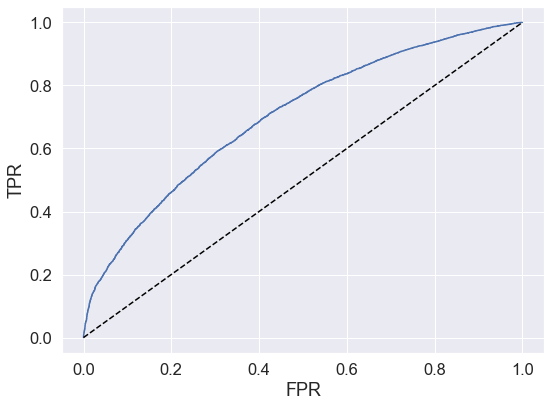

In [25]:
# plot ROC_AUC
sns.set()
sns.set(font_scale=1.5)

y_pred_proba_test = opt_xgb_clf.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout()

Text(0.5, 1.0, 'Confusion matrix')

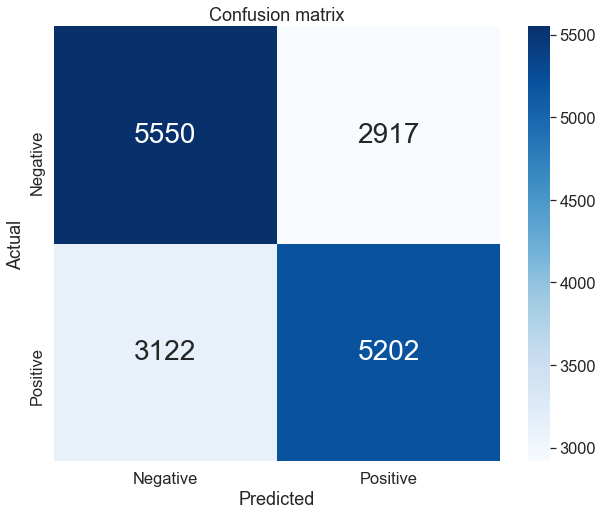

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

lables = {'Negative': 0, 'Positive': 1} 

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, 
            annot=True,
            annot_kws={'size':28},
            fmt='d',
            xticklabels=lables.keys(), 
            yticklabels=lables.keys(),
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

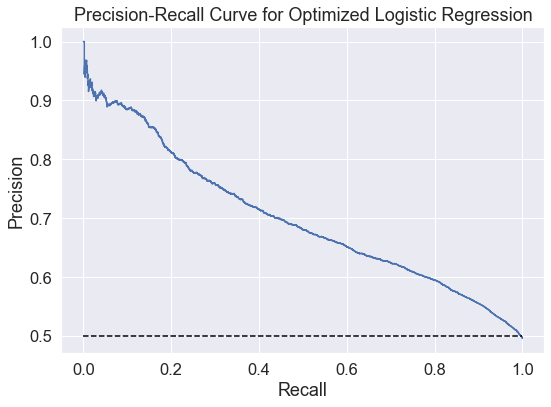

In [27]:
# plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.plot([0, 1], [0.5, 0.5], '--', color = 'black')
plt.title('Precision-Recall Curve for Optimized Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

In [28]:
search.best_params_

{'preprocessor__num__strategy': 'median',
 'preprocessor__id__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 0.7,
 'classifier__n_estimators': 1500,
 'classifier__min_child_weight': 3,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0.1}

In [29]:
# Preprocessing for numerical data
numerical_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__num__strategy'])

# Preprocessing for binary data
binary_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__bin__strategy'])

# Preprocessing for categorical data encoded as numerical ID's
id_transformer_rev = SimpleImputer(strategy=search.best_params_['preprocessor__id__strategy'])

# Preprocessing for categorical data
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, num_col),
        ('bin', binary_transformer_rev, binary_col),
        ('id', id_transformer_rev, id_col),
        ('cat', categorical_transformer_rev, cat_col)
    ])

# Bundle preprocessing and modeling code in a pipeline
pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])

In [30]:
chosen_feat = opt_xgb_clf.named_steps['VarThresh'].get_support()
list(enumerate(chosen_feat))

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True),
 (9, True),
 (10, True),
 (11, True),
 (12, True),
 (13, True),
 (14, False),
 (15, True),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, True),
 (38, True),
 (39, True),
 (40, True),
 (41, True),
 (42, True),
 (43, True),
 (44, True),
 (45, True),
 (46, True),
 (47, True),
 (48, True),
 (49, True),
 (50, True),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, True),
 (56, True),
 (57, True),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, True),
 (63, True),
 (64, True),
 (65, True),
 (66, True),
 (67, True),
 (68, True),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, True),
 (74, True),
 (75, True),
 (76, True),
 (77, Tr

In [31]:
X_values = preprocessor_rev.fit_transform(X_train)
onehot_col = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_tot = num_col + binary_col + id_col + onehot_col.tolist()
columns_tot = [feat for bool_, feat in zip(chosen_feat, columns_tot) if bool_]

feature_importance = pd.Series(data=opt_xgb_clf.named_steps['classifier'].feature_importances_,
                               index = np.array(columns_tot))

In [32]:
feature_importance = feature_importance.sort_values(ascending=False)

<AxesSubplot:>

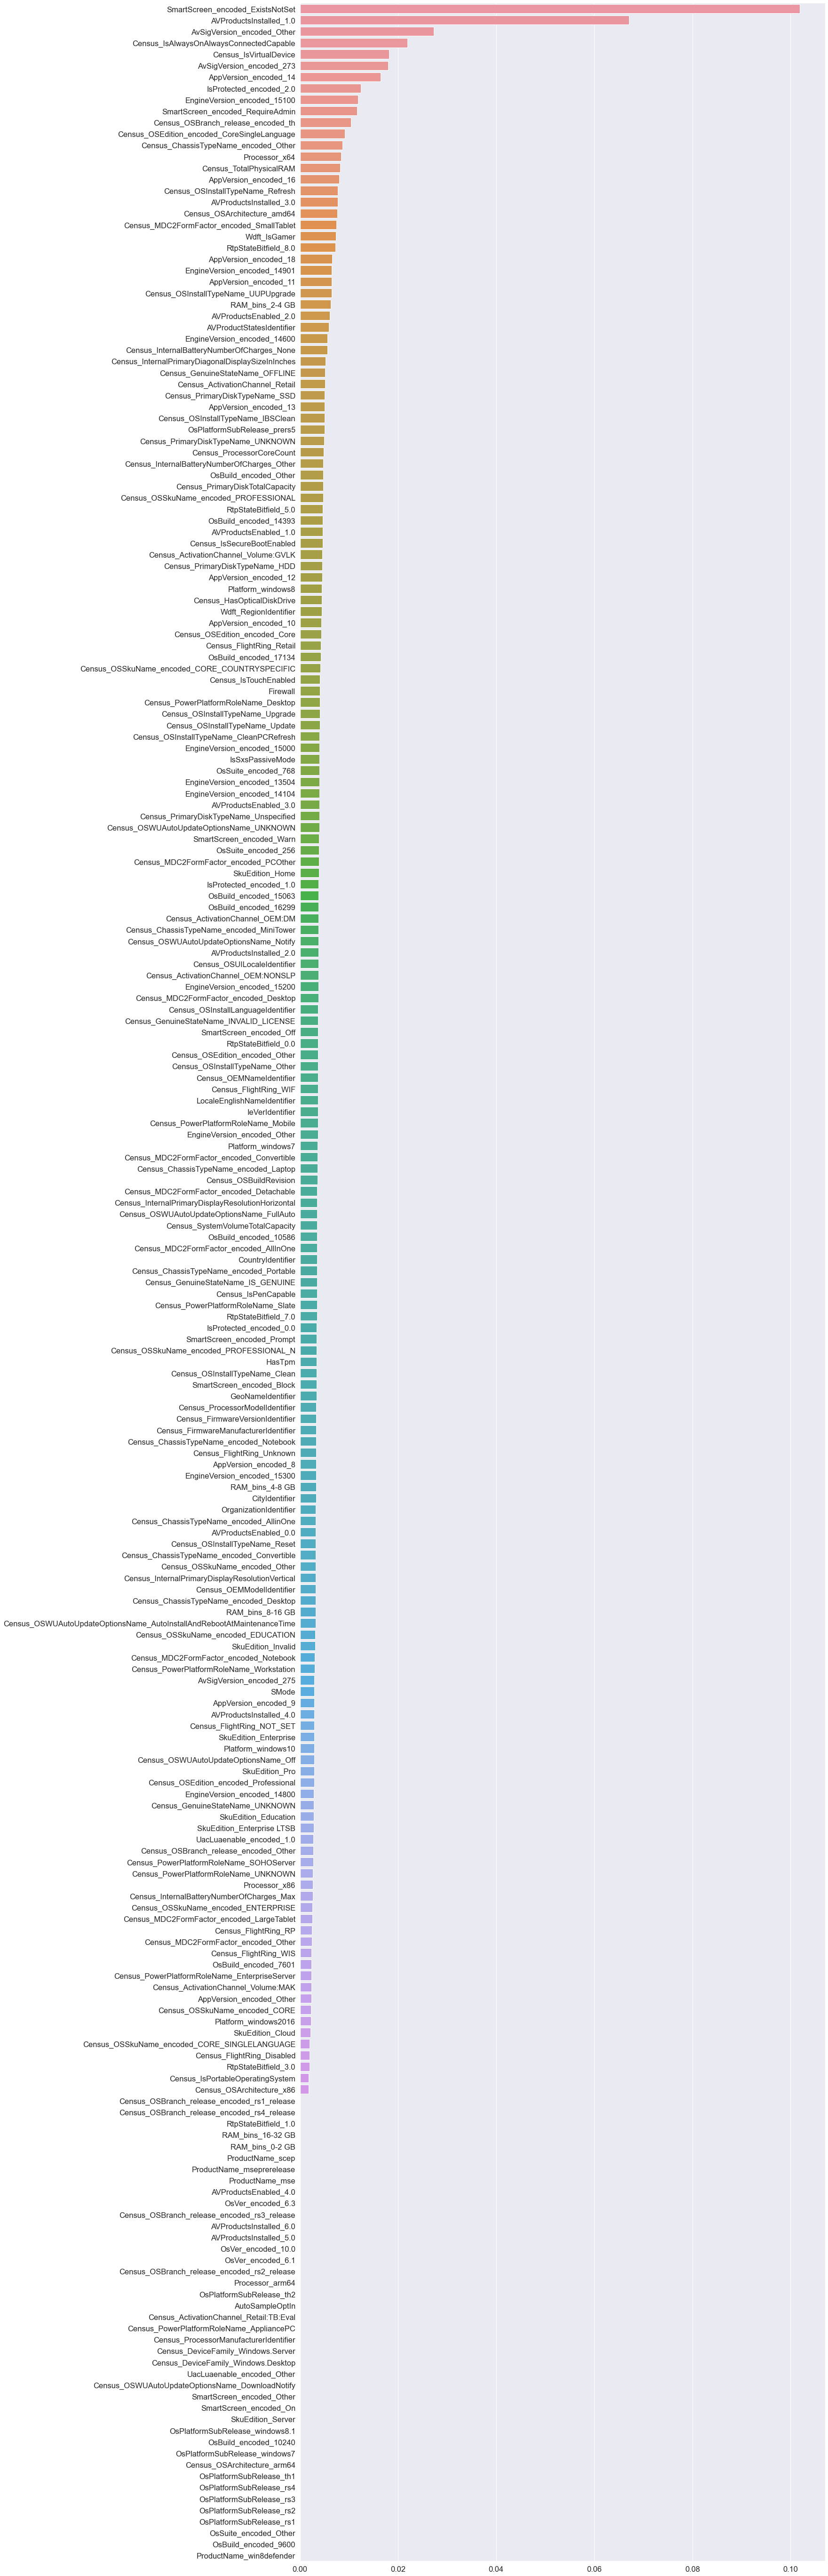

In [33]:
plt.figure(figsize=(20,100))
sns.barplot(y=feature_importance.index, 
            x=feature_importance.values, 
            orient='h')

In [35]:
# Learning curve
opt_xgb_clf_rev = opt_xgb_clf
train_sizes, train_scores, test_scores = learning_curve(opt_xgb_clf_rev, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=3, 
                                                        scoring='roc_auc',
                                                        n_jobs=1,
                                                        train_sizes=np.linspace(.01, 1.0, 4), 
                                                        verbose=3)

[learning_curve] Training set sizes: [  447 15223 29998 44774]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ..................., score=(train=1.000, test=0.561) total time=   1.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] END ..................., score=(train=0.911, test=0.676) total time=  25.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.1s remaining:    0.0s


[CV] END ..................., score=(train=0.844, test=0.688) total time=  49.6s
[CV] END ..................., score=(train=0.812, test=0.700) total time= 1.2min
[CV] END ..................., score=(train=1.000, test=0.591) total time=   2.1s
[CV] END ..................., score=(train=0.908, test=0.672) total time=  24.7s
[CV] END ..................., score=(train=0.845, test=0.690) total time=  47.7s
[CV] END ..................., score=(train=0.814, test=0.699) total time= 1.2min
[CV] END ..................., score=(train=1.000, test=0.586) total time=   2.0s
[CV] END ..................., score=(train=0.908, test=0.668) total time=  24.7s
[CV] END ..................., score=(train=0.846, test=0.686) total time=  48.6s
[CV] END ..................., score=(train=0.815, test=0.693) total time= 1.2min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  7.5min finished


Text(0.5, 1.0, 'Learning Curve (XGB)')

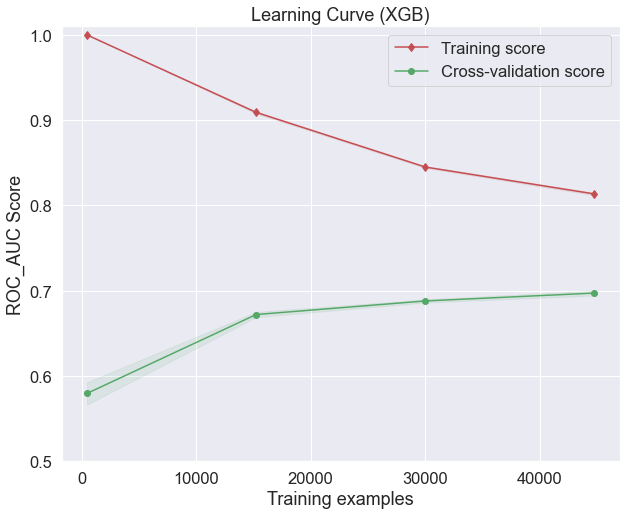

In [36]:
# Plot learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color='g')
plt.plot(train_sizes, train_scores_mean, 'd-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
plt.ylim(0.5, 1.01)
   
    
plt.legend(loc='best')
plt.xlabel('Training examples')
plt.ylabel('ROC_AUC Score')
plt.title('Learning Curve (XGB)')

In [37]:
# Retrain on full dataset

In [38]:
df = pd.read_pickle('../data/interim/train_clean_roll_up.pickle')

In [39]:
X = df.loc[:, df.columns != 'HasDetections']
y = df['HasDetections']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X,
                                                                        y,
                                                                        test_size = 0.2,
                                                                        random_state = 10)

(67162, 71)
(16791, 71)
(67162,)
(16791,)


In [40]:
print(X_train_full.shape)
print(X_test_full.shape)
print(y_train_full.shape)
print(y_test_full.shape)

(6716272, 71)
(1679069, 71)
(6716272,)
(1679069,)


In [41]:
y_train_full.mean(), y_test_full.mean()

(0.498492913926059, 0.49847623891573245)

In [42]:
y_train_full = y_train_full.astype('int')
y_test_full = y_test_full.astype('int')

for col in cat_col:
    X_train_full[col] = X_train_full[col][X_train_full[col].notnull()].astype('str')
    X_train_full[col] = X_train_full[col].astype('category')
    X_test_full[col] = X_test_full[col][X_test_full[col].notnull()].astype('str')
    X_test_full[col] = X_test_full[col].astype('category')

<ipython-input-42-63b7f122abb8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_full[col] = X_train_full[col][X_train_full[col].notnull()].astype('str')
<ipython-input-42-63b7f122abb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_full[col] = X_train_full[col].astype('category')
<ipython-input-42-63b7f122abb8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
# Define model
#xgb_clf_full = xgb.XGBClassifier(         )

#VarThresh = VarianceThreshold()

# Bundle preprocessing and modeling code in a pipeline
#from sklearn.pipeline import make_pipeline

#pipeline_full = Pipeline(steps=[('preprocessor', preprocessor_rev),
#                                ('VarThresh', VarThresh),
#                                ('classifier', xgb_clf_full)
#                               ])

In [ ]:
#pipeline_full.fitX_trainrain_full, y_train_full)

In [ ]:
#cv_results = cross_validate(pipeline_full, X_train_full, y_train_full, cv=5, scoring='roc_auc')

In [43]:
opt_xgb_clf.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Census_ProcessorCoreCount',
                                                   'Census_PrimaryDiskTotalCapacity',
                                                   'Census_SystemVolumeTotalCapacity',
                                                   'Census_TotalPhysicalRAM',
                                                   'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                   'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                   'Census_InternalPr...
                               gamma=0.1, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=1500,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=0))])

In [ ]:
#cross_val_score(opt_xgb_clf, X_train_full, y_train_full, cv=5)

In [44]:
# Predictions
y_pred_train_full = opt_xgb_clf.predict(X_train_full)
y_pred_test_full = opt_xgb_clf.predict(X_test_full)

print('Train Set roc auc:', roc_auc_score(y_train_full, y_pred_train_full))
print('Test Set roc auc:', roc_auc_score(y_test_full, y_pred_test_full))

Train Set roc auc: 0.6565162882606111
Test Set roc auc: 0.6554161896507585


In [45]:
with open('../models/optimized_XGB.pickle', 'wb') as handle:
    pickle.dump(opt_xgb_clf, handle)